In [45]:
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# read in movie csv
movies = pd.read_csv('/Users/zachwayne/Dropbox (MIT)/Netflix - Seize the Data/movies.csv')


In [507]:
df = pd.read_csv('/Users/zachwayne/Dropbox (MIT)/Netflix - Seize the Data/feed_into_pipeline_data_with_weeks.csv')
summaries = pd.read_csv('/Users/zachwayne/Dropbox (MIT)/Netflix - Seize the Data/GlobalOriginalsWithSummary.csv')[['combined_title', 'summary']]
people_rankings = pd.read_csv('/Users/zachwayne/Dropbox (MIT)/Netflix - Seize the Data/showsWithPrinicpalVotes.csv')[['combined_title', 'director_votes', 'writer_votes', 'actor_votes']]
df = df.merge(summaries, on='combined_title')
df = df.merge(people_rankings, on='combined_title')
# delete is_top_ten
del df['is_top10']
# make all current_weeks >= 1 to 1
df['cumulative_weeks_in_top_10'] = df['cumulative_weeks_in_top_10'].apply(lambda x: 1 if x >= 1 else 0)
# if language is not english, make it Non-English
df['language'] = df['language'].apply(lambda x: 'Non-English' if x != 'English' else x)
movies, tv_shows = df[df['is_tv_show']==False], df[df['is_tv_show']==True]
movies = movies.set_index('tconst')
movies = movies.drop(['tconst', 'release_date', 'combined_title', 'lower_title', 'season', 'is_tv_show'], axis = 1, errors = 'ignore')

In [508]:
# train test split with stratified sampling
from sklearn.model_selection import train_test_split

#movie_X_train, movie_X_test, movie_y_train, movie_y_test = train_test_split(movies.drop('is_top10', axis=1), movies['is_top10'], test_size=0.2, random_state=42, stratify=movies['is_top10'])
movie_X_train, movie_X_test, movie_y_train, movie_y_test = train_test_split(movies.drop('cumulative_weeks_in_top_10', axis=1), movies['cumulative_weeks_in_top_10'], test_size=0.2, random_state=42)

In [48]:
movie_X_test.shape

(184, 15)

In [509]:
movie_X_train

,release_year,averageRating,numVotes,titleType,runtimeMinutes,genres,release_date_quarter,release_date_month,release_date_week,language,violence,summary,director_votes,writer_votes,actor_votes
tconst,,,,,,,,,,,,,,,
tt9242528,2022,6.7,3593,movie,129.0,"Biography,Drama,Sport",2,5,18,English,None,"After World War II, Harry Haft is a boxer who ...",1598423.0,318516.000000,8.469520e+05
tt14174168,2022,3.8,2009,movie,97.0,"Action,Thriller",2,4,17,English,None,A man implicated in the triple homicide of thr...,1749.0,17482.500000,5.645233e+05
tt7456312,2020,4.3,15583,movie,115.0,"Crime,Drama,Thriller",1,2,8,English,Moderate,A veteran D.C. journalist loses the thread of ...,260292.0,184623.000000,4.827643e+06
tt10307440,2020,6.0,8939,movie,83.0,"Action,Thriller",1,3,13,Non-English,None,A fatal accident at a remote survivalist train...,9046.0,8954.666667,1.039000e+04
tt10798934,2020,6.5,378,tvSpecial,59.0,Comedy,4,12,49,English,None,Meet Nate - your stereotypical masculine man j...,452.0,NaN,5.546000e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt11057594,2020,4.6,6137,movie,89.0,Thriller,3,7,29,English,None,Ellie tries to mend her marriage with her husb...,61564.0,65026.333333,1.835523e+05
tt12689876,2020,6.5,541,tvSpecial,64.0,Comedy,3,8,32,English,None,"Comedian and ""Saturday Night Live"" writer Sam ...",1095.0,50144.000000,1.087000e+03
tt8923484,2020,7.7,7616,movie,106.0,"Documentary,History",1,3,13,English,Moderate,"Down the road from Woodstock, a revolution blo...",7570.0,21068.666667,7.570000e+03


In [568]:
from sklearn.feature_extraction.text import TfidfVectorizer
rankings_pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='mean')),
    ('logger', FunctionTransformer(np.log1p))
])

xgb_transformer = ColumnTransformer(
    [
        ("onehot_titleType",OneHotEncoder(handle_unknown='ignore'), ['titleType']),

        #("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),
        ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),
        #("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),
        #("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),
        #("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),
        ("onehot_l",OneHotEncoder(handle_unknown='ignore'), ['language']),

        ("onehot_release_year",OneHotEncoder(handle_unknown='ignore'), ['release_year']),
        #("bagofwords", CountVectorizer(stop_words='english', min_df=0.02), 'summary'),
        #("tfidf", TfidfVectorizer(stop_words='english', min_df=0.02), 'summary'),
        ("genres_count", CountVectorizer(min_df=0.05), 'genres'),
        #("sentence_transformer", embedder, 'summary'),
        #("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),
        ("rankings_pipeline", rankings_pipeline, ['director_votes', 'actor_votes', 'writer_votes']),
    ],
    remainder='passthrough')

In [569]:
# Recreate pipeline using XGBoost

xgb_pipe = Pipeline(
    steps=[
        ('xgb_transformer', xgb_transformer),
        #('normalizer', sklearn.preprocessing.Normalizer()),
        ('xgb', XGBClassifier())
    ]
)

xgb_gs = GridSearchCV(
    xgb_pipe,
    param_grid={
        'xgb__max_depth': [3, 5, 7],
        'xgb__learning_rate': [0.01, 0.1, 0.5],
        'xgb__n_estimators': [100, 200, 300]
    },
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [570]:
# movie_X_train drop summart
xgb_gs.fit(movie_X_train.drop('summary', axis=1), movie_y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgb_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot_titleType',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('onehot_v',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['violence']),
                                                                        ('onehot_l',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                            

In [460]:
feature_names = xgb_gs.best_estimator_.named_steps['xgb_transformer'].transformers_[4][1].get_feature_names_out()
feature_names

array(['action', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'documentary', 'drama', 'family', 'mystery', 'romance', 'thriller'],
      dtype=object)

In [571]:
colsW = ['x0_movie', 'x0_short', 'x0_tvSpecial','x0_Mild', 'x0_Moderate', 'x0_None', 'x0_Severe','x0_English', 'x0_Non-English','x0_2020', 'x0_2021', 'x0_2022','action', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'documentary', 'drama', 'family', 'mystery', 'romance', 'thriller', 'director_votes','actor_votes','writer_votes','averageRating','numVotes','runtimeMinutes','release_date_quarter','release_date_month',"release_date_week"]

In [480]:
# make colsW a dataframe with each value as a column name
colsW2 = pd.DataFrame(columns=colsW)
colsW2

,x0_movie,x0_short,x0_tvSpecial,x0_Mild,x0_Moderate,x0_None,x0_Severe,x0_English,x0_Non-English,x0_2020,...,thriller,director_votes,actor_votes,writer_votes,averageRating,numVotes,runtimeMinutes,release_date_quarter,release_date_month,release_date_week


In [481]:
# add row to colsW2
colsW2.loc[0] = colsW

In [482]:
colsW2

,x0_movie,x0_short,x0_tvSpecial,x0_Mild,x0_Moderate,x0_None,x0_Severe,x0_English,x0_Non-English,x0_2020,...,thriller,director_votes,actor_votes,writer_votes,averageRating,numVotes,runtimeMinutes,release_date_quarter,release_date_month,release_date_week
0,x0_movie,x0_short,x0_tvSpecial,x0_Mild,x0_Moderate,x0_None,x0_Severe,x0_English,x0_Non-English,x0_2020,...,thriller,director_votes,actor_votes,writer_votes,averageRating,numVotes,runtimeMinutes,release_date_quarter,release_date_month,release_date_week


In [549]:
# get model performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

y_pred = xgb_gs.predict(movie_X_test.drop(columns=['summary']))
print('Mean Squared Error:', mean_squared_error(movie_y_test, y_pred))
print('Mean Absolute Error:', mean_absolute_error(movie_y_test, y_pred))
print('R2 Score:', r2_score(movie_y_test, y_pred))

Mean Squared Error: 0.09782608695652174
Mean Absolute Error: 0.09782608695652174
R2 Score: 0.241758241758242


In [550]:
# baseline model
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(movie_X_train.drop(columns=['summary']), movie_y_train)
dummy_regr.predict(movie_X_test.drop(columns=['summary']))
print('Mean Squared Error:', mean_squared_error(movie_y_test, dummy_regr.predict(movie_X_test.drop(columns=['summary']))))
# compare mse to model
(r2_score(movie_y_test, y_pred) - r2_score(movie_y_test, dummy_regr.predict(movie_X_test.drop(columns=['summary']))))/abs(r2_score(movie_y_test, dummy_regr.predict(movie_X_test.drop(columns=['summary']))))
(mean_squared_error(movie_y_test, dummy_regr.predict(movie_X_test.drop(columns=['summary']))) - mean_squared_error(movie_y_test, y_pred))/abs(mean_squared_error(movie_y_test, dummy_regr.predict(movie_X_test.drop(columns=['summary']))))

Mean Squared Error: 0.1290834711720227


0.2421486185000859

In [552]:
# find highest ypred
y_pred = xgb_gs.predict(movie_X_test.drop(columns=['summary']))
y_pred = pd.DataFrame(y_pred, columns=['y_pred'])
y_pred['y_test'] = movie_y_test
y_pred['title'] = movie_X_test.index
y_pred['diff'] = y_pred['y_pred'] - y_pred['y_test']
y_pred.sort_values(by='diff', ascending=True).head(10)


,y_pred,y_test,title,diff
0,0,NaN,tt13058374,NaN
1,0,NaN,tt13472984,NaN
2,0,NaN,tt15091640,NaN
3,0,NaN,tt12888462,NaN
4,1,NaN,tt15033192,NaN
5,0,NaN,tt10675724,NaN
6,0,NaN,tt14539726,NaN
7,0,NaN,tt19072490,NaN
8,0,NaN,tt7395114,NaN
9,0,NaN,tt10329134,NaN


In [572]:
xgb_gs.best_score_
#0.825311 no summary
#0.827196 with bow summary
#0.825758 with tfidf summary

0.9383254311825739

In [573]:
# test auc
from sklearn.metrics import roc_auc_score
y_pred = xgb_gs.predict_proba(movie_X_test.drop(columns=['summary']))[:,1]
roc_auc_score(movie_y_test, y_pred)

0.8843864468864469

In [574]:
# model accuracy
xgb_gs.score(movie_X_test.drop(columns=['summary']), movie_y_test)


0.8843864468864469

In [575]:
# model f1 score
from sklearn.metrics import f1_score
y_pred = xgb_gs.predict(movie_X_test.drop(columns=['summary']))
f1_score(movie_y_test, y_pred, average='weighted')

0.8906455862977601

In [587]:
# predict probabilities
y_pred = xgb_gs.best_estimator_.predict_proba(movie_X_test.drop(columns=['summary']))
y_pred = pd.DataFrame(y_pred, columns=['y_pred_0', 'y_pred_1'])
y_pred['title'] = movie_X_test.index
y_pred['actual'] = movie_y_test.to_numpy()
# delete movies that are not top 10
y_pred = y_pred[y_pred['actual']==0]
y_pred.sort_values(by='y_pred_1', ascending=False).head(20)


,y_pred_0,y_pred_1,title,actual
55,0.760260,0.239740,tt5748448,0
180,0.768403,0.231597,tt10962368,0
96,0.777964,0.222036,tt12141112,0
35,0.808344,0.191656,tt5498354,0
181,0.815322,0.184678,tt9731386,0
24,0.815355,0.184645,tt21340412,0
70,0.855721,0.144279,tt7392014,0
69,0.867780,0.132220,tt7846844,0
162,0.869343,0.130657,tt11100856,0
33,0.877642,0.122358,tt11199410,0


In [467]:
# show with

In [586]:
y_pred = xgb_gs.predict_proba(movie_X_train.drop(columns=['summary']))
y_pred = pd.DataFrame(y_pred, columns=['y_pred_0', 'y_pred_1'])
y_pred['title'] = movie_X_train.index
y_pred['actual'] = movie_y_train.to_numpy()
# delete movies that are not top 10
y_pred = y_pred[y_pred['actual']== 0]
y_pred.sort_values(by='y_pred_1', ascending=False).head(20)

,y_pred_0,y_pred_1,title,actual
626,0.036494,0.963506,tt6111574,0
587,0.064088,0.935912,tt15101956,0
726,0.098150,0.901850,tt11209212,0
74,0.109432,0.890568,tt15085784,0
481,0.162288,0.837712,tt1587420,0
566,0.168629,0.831371,tt9013182,0
364,0.184947,0.815053,tt7084386,0
580,0.198261,0.801739,tt6733874,0
108,0.235690,0.764310,tt14544192,0
150,0.244654,0.755346,tt10293406,0


In [410]:
# language of tconst = tt15432804
tv_shows[tv_shows['tconst']=='tt15432016']

,combined_title,release_year,release_date,lower_title,season,is_tv_show,tconst,averageRating,numVotes,titleType,...,release_date_quarter,release_date_month,release_date_week,cumulative_weeks_in_top_10,language,violence,summary,director_votes,writer_votes,actor_votes
484,Devil in Ohio: Limited Series,2022,9/2/22,devil in ohio limited series,1.0,True,tt15432016,5.9,13405,tvMiniSeries,...,3,9,35,1,English,None,When a psychiatrist shelters a mysterious cult...,346922.0,71403.0,8361.0


In [370]:
import shap

In [582]:
model = xgb_gs.best_estimator_['xgb'].fit(xgb_gs.best_estimator_['xgb_transformer'].transform(movie_X_train), movie_y_train)
modelTest = xgb_gs.best_estimator_['xgb'].fit(xgb_gs.best_estimator_['xgb_transformer'].transform(movie_X_test), movie_y_test)



In [583]:
explainer = shap.Explainer(model, xgb_gs.best_estimator_['xgb_transformer'].transform(movie_X_train), feature_names=colsW , model_output='probability')
explainerTest = shap.Explainer(model, xgb_gs.best_estimator_['xgb_transformer'].transform(movie_X_test), feature_names=colsW , model_output='probability')



In [584]:
shap_values = explainer(xgb_gs.best_estimator_['xgb_transformer'].transform(movie_X_train))
shap_valuesTest = explainer(xgb_gs.best_estimator_['xgb_transformer'].transform(movie_X_test))


In [560]:
#make a dataframe with the shap values
shap_values_df = pd.DataFrame(shap_values.data, columns=colsW)
shap_values_df_test = pd.DataFrame(shap_valuesTest.data, columns=colsW)


In [489]:
# find numVotes = 7912
shap_values_df[shap_values_df['numVotes']==1182]

,x0_movie,x0_short,x0_tvSpecial,x0_Mild,x0_Moderate,x0_None,x0_Severe,x0_English,x0_Non-English,x0_2020,...,thriller,director_votes,actor_votes,writer_votes,averageRating,numVotes,runtimeMinutes,release_date_quarter,release_date_month,release_date_week
451,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,6.381816,7.950032,7.239215,3.9,1182.0,92.0,2.0,5.0,20.0


In [490]:
shap_values_df_test[shap_values_df_test['numVotes']==1182]

,x0_movie,x0_short,x0_tvSpecial,x0_Mild,x0_Moderate,x0_None,x0_Severe,x0_English,x0_Non-English,x0_2020,...,thriller,director_votes,actor_votes,writer_votes,averageRating,numVotes,runtimeMinutes,release_date_quarter,release_date_month,release_date_week


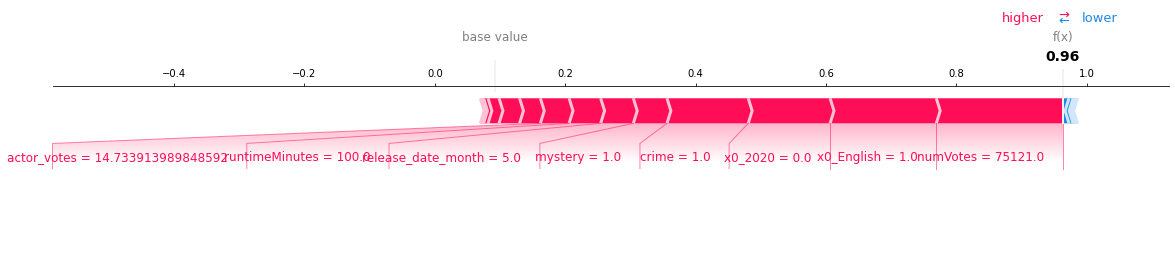

In [588]:
# force plot
shap.plots.force(shap_values[626], matplotlib=True)

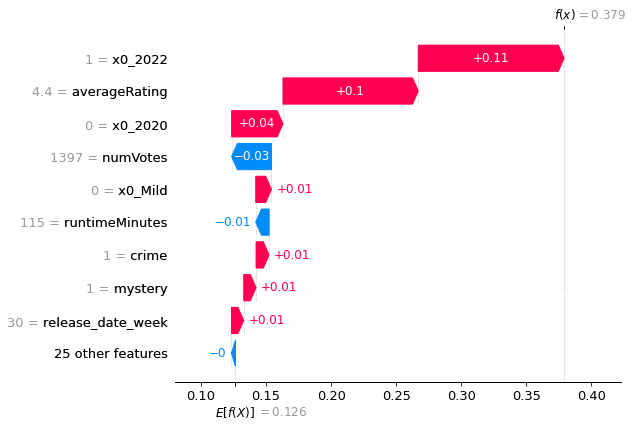

In [203]:
shap.plots.waterfall(shap_values[155])
# make y-axis font white